In [10]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys, os,os.path
ROOT_PATH = os.path.abspath("..").split("data_processing")[0]
module_paths = []
module_paths.append(os.path.abspath(os.path.join(ROOT_PATH+"/data_processing/")))
module_paths.append(os.path.abspath(os.path.join(ROOT_PATH+"/hybrid_analysis_process_functions/")))
module_paths.append(os.path.abspath(os.path.join(ROOT_PATH+"/utils/")))
for module_path in module_paths:
    if module_path not in sys.path:
        print("appended")
        sys.path.append(module_path)
%autoreload
from scipy import stats
import functions as f
import wt_data, ff_transform, explore_fft_time_data, envelope, build_dataset, load_raw_signals, envelope, envelope_emd,plotting_methods
import resample_signals, filter_signals, plotting_methods,filters,correlation_coeff, feature_extraction,polycoherence

### Need the raw signal

In [12]:
# need the raw signal
_, times, op_data_intervals, _ = load_raw_signals.load_raw('gearbox','wt04')

File exist


In [13]:
t0 = times[0][20000]
t0

0.78125

In [14]:
(op_data_intervals)

,Unnamed: 0,AvgPower,ActPower,WindSpeed,NacelleDirection,AvgSpeed
0,0,487.811127,387.100006,5.7,236.699997,1000.724591
1,1,2697.461426,2332.100098,9.1,256.100006,1456.464986
2,2,2606.151855,2843.500000,10.0,240.199997,1468.503663
3,3,2541.849854,2694.100098,10.5,71.099998,1458.875183
4,4,2853.304199,3293.399902,12.7,269.399994,1460.635409
...,...,...,...,...,...,...
419,419,2565.862793,1585.199951,7.7,358.799988,1420.395518
420,420,2891.829346,2819.300049,10.4,318.600006,1487.214505
421,421,2581.525879,3160.600098,10.2,317.000000,1489.520070
422,422,459.051758,401.200012,5.4,267.000000,887.233392


In [15]:
i=0 # selecting the first interval for now
path=f'/Volumes/OsvikExtra/signal_data/raw_filtered_6000Hz/gearbox/wt04/eemd_signals/interval_number_{i}.csv'
df = pd.read_csv(path, header=None)
df.shape

(14, 20000)

(20000,)

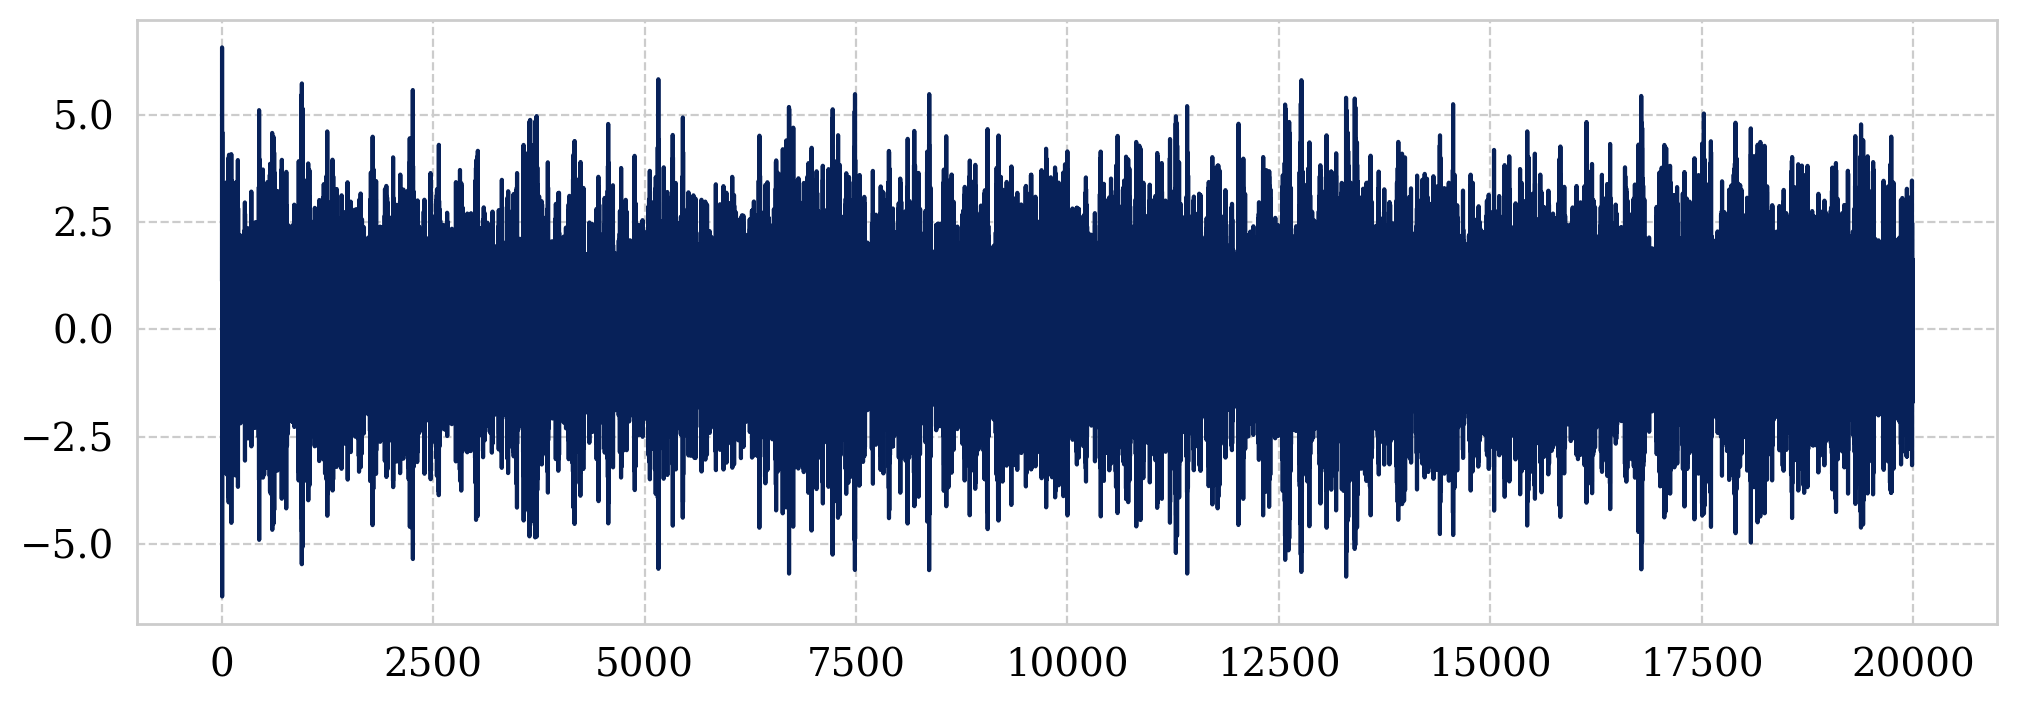

In [16]:
# Plotting one of the EEMD intervals
j=1 # This is the first IMF. j=0 is the signal.
df.iloc[j].plot()
s = df.iloc[j]
s.shape

### Rectify + lp_filter

In [17]:
selected_IMF_index = j
fs=25600
highut_lp = 2000
rectified = abs(s)**2
bandpass_filtered_rect_lp = filters.butter_lp_filter(rectified, highut_lp, fs, order=5)

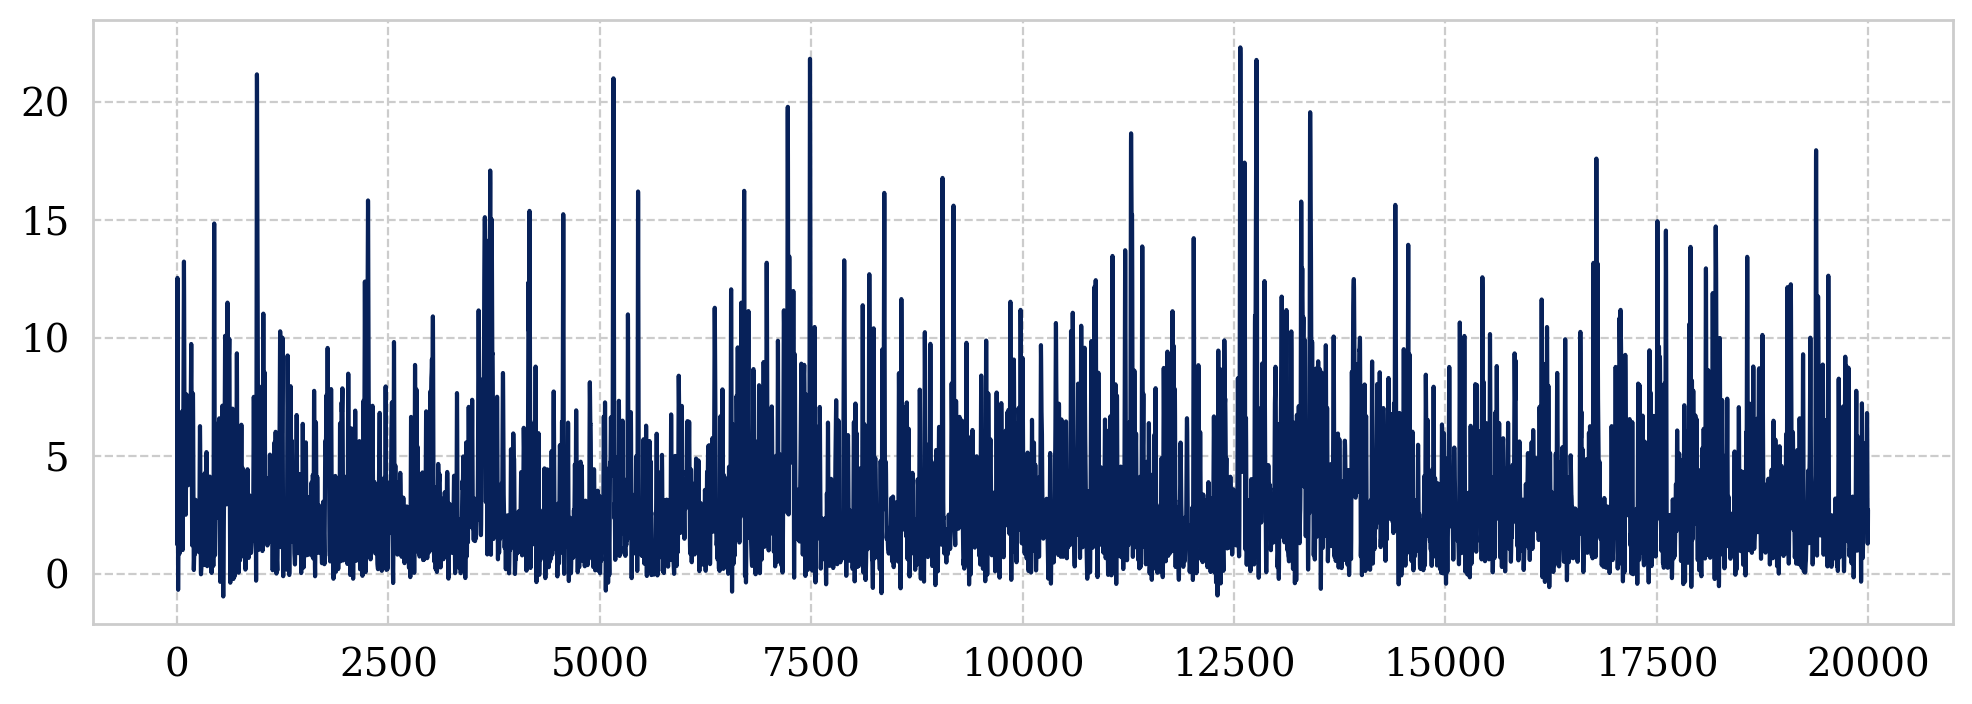

In [18]:
plt.plot(bandpass_filtered_rect_lp)

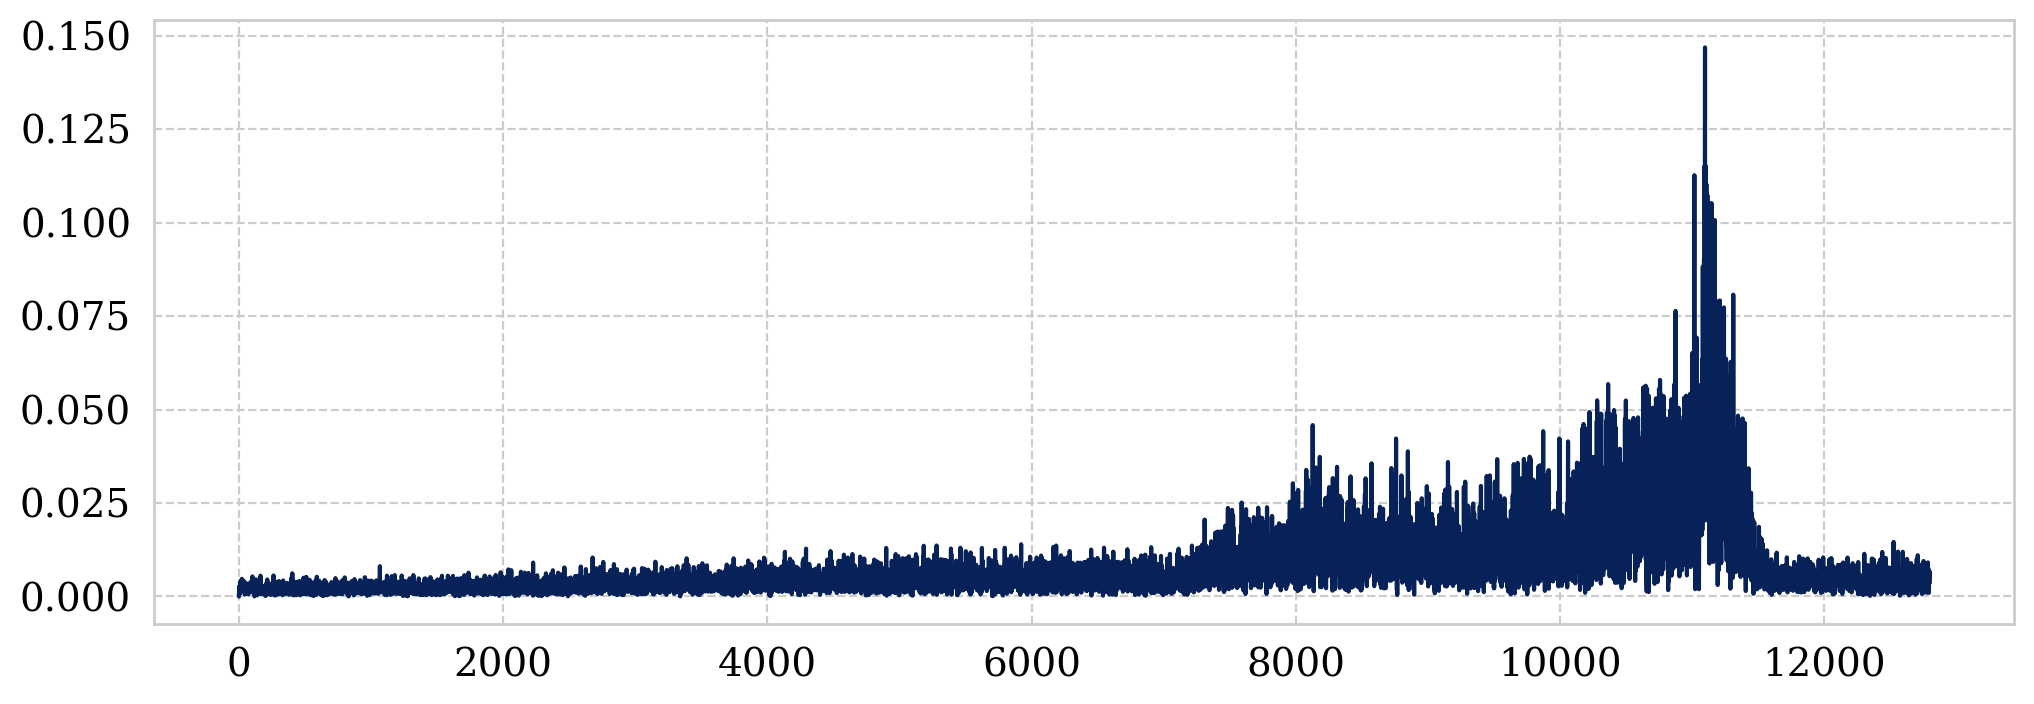

In [27]:
t = times[0][0:20000]
sig = s
mean_amplitude = np.mean(sig)
sig = sig - mean_amplitude  # Centering around 0
fft = np.fft.fft(sig)
N = sig.size
T = t[1] - t[0]

f = np.linspace(0, 1 / T, N, )  # start, stop, number of. 1 / T = frequency is the biggest freq

f = f[:N // 2]
y = np.abs(fft)[:N // 2]
y_norm = np.abs(fft)[:N // 2] * 1 / N  # Normalized
plt.plot(f,y_norm)

In [19]:
timestamps = times[0][0:20000]

# Bispectrum

In [32]:
N = len(s)
f= N//times[0][20000]
f

25600.0

(20000,)


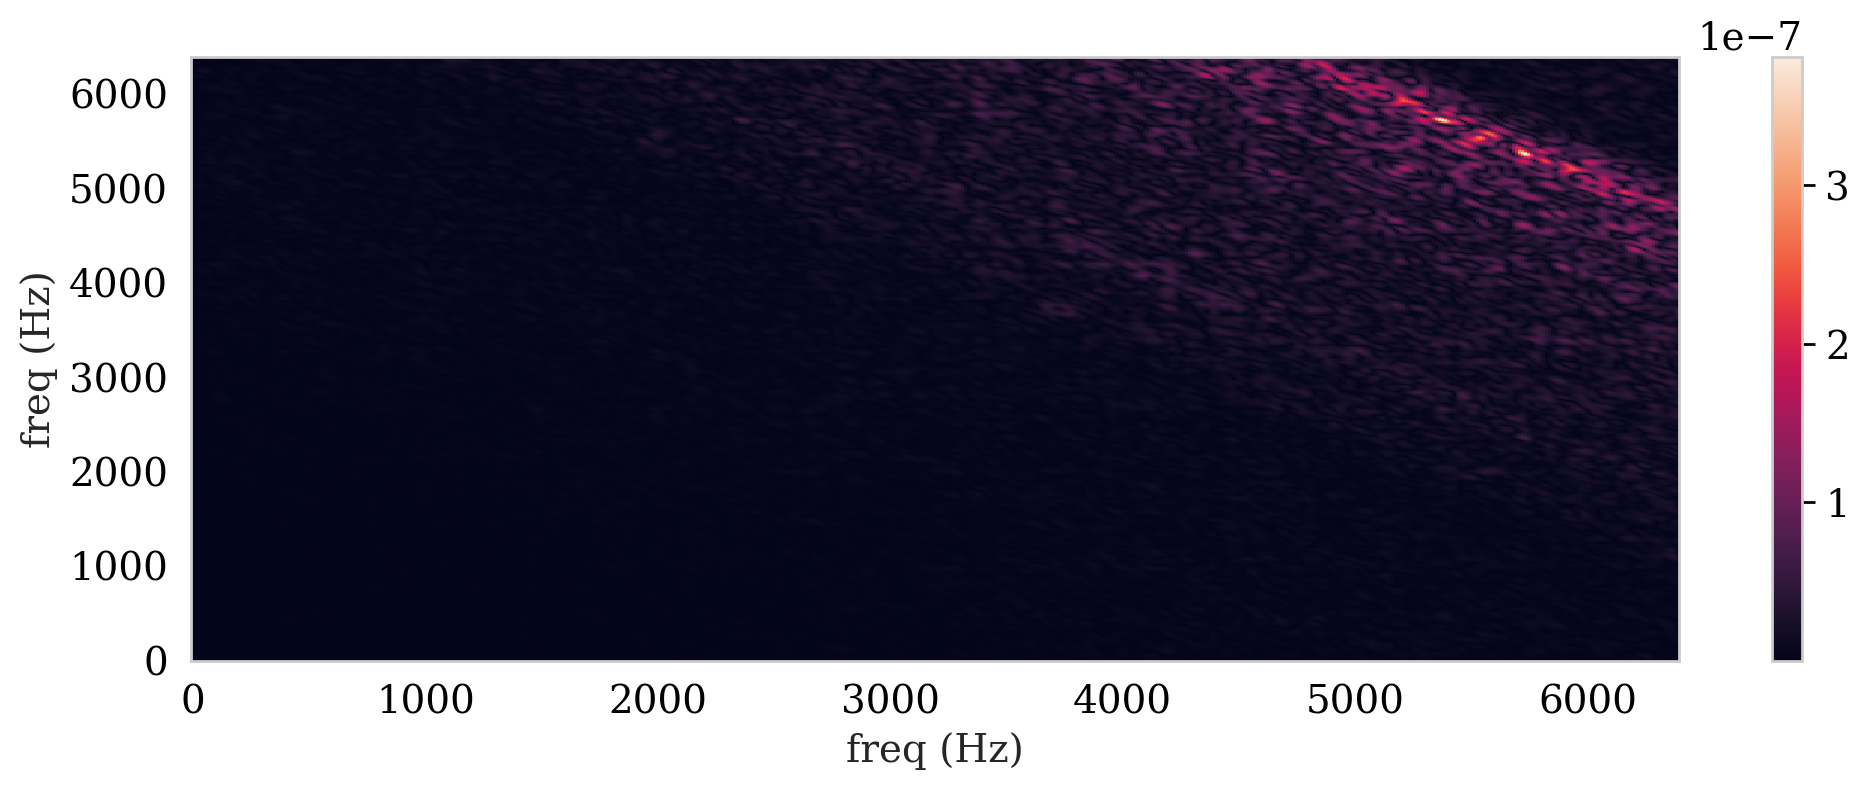

In [41]:
from math import pi
import numpy as np
from numpy.fft import rfftfreq, rfft
from scipy.fftpack import next_fast_len
from scipy.signal import spectrogram
import matplotlib.pyplot as plt

print(s.shape) # (20000,)

N=4000 # Select the N to split the signal into N parts
kw = dict(nperseg=N // 10, noverlap=N // 20, nfft=next_fast_len(N // 2))
freq1, fre2, bispec = polycoherence.polycoherence(s, fs, norm=None, **kw)
polycoherence.plot_polycoherence(freq1, fre2, bispec)

In [54]:
# Extracting features from this

# 1. Sum of logarithmic amplitudes of the bi-spectrum
f_1 = np.sum(np.log(np.abs(bispec)))

# 2. Sum of logarithmic amplitudes of diagonal elements in the bi-spectrum
f_2 = np.sum(np.diag(np.abs(bispec)))

# 3. First order spectral moment of amplitudes of diagonal elements in the bi spectrum
f_3 = np.log(np.abs(bispec))

# implement this 


1.09463e-05